In [3]:
import os
import genomepy
import pandas as pd
from torch.nn import functional as F
import torch
import numpy as np
import pyranges
import matplotlib.pyplot as plt

In [4]:
rnaseq = pd.read_table("data/rnaseq/rnaseq.rsem_genes_fpkm.txt")

In [5]:
rnaseq

,gene_id,gene_name,0001_GSE86189_Thymus_0,0001_GSE86189_Thymus_1,0001_GSE86189_Thymus_2,0001_GSE86189_Thymus_3,0001_GSE86189_Thymus_4,0002_GSE86189_Embryo - Trophoblast_0,0003_GSE86189_Spleen_0,0003_GSE86189_Spleen_1,...,0064_EGAD00001002268_Blood - Megakaryocytes_1,0064_EGAD00001002268_Blood - Megakaryocytes_2,0067_EGAD00001002268_Blood - Total CD4+ Cells_0,0067_EGAD00001002268_Blood - Total CD4+ Cells_1,0067_EGAD00001002268_Blood - Total CD4+ Cells_2,0067_EGAD00001002268_Blood - Total CD4+ Cells_3,0067_EGAD00001002268_Blood - Total CD4+ Cells_4,0067_EGAD00001002268_Blood - Total CD4+ Cells_5,0067_EGAD00001002268_Blood - Total CD4+ Cells_6,0067_EGAD00001002268_Blood - Total CD4+ Cells_7
0,ENSG00000223972,DDX11L1,0.00,0.04,0.12,0.06,0.07,0.01,0.00,0.00,...,1.67,0.89,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00
1,ENSG00000243485,MIR1302-2HG,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.11,...,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00
2,ENSG00000227232,WASH7P,12.26,12.87,13.71,12.41,13.05,7.76,12.95,11.23,...,0.96,1.43,13.93,13.39,9.01,5.85,19.11,9.84,11.07,12.35
3,ENSG00000237613,FAM138A,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.01,0.00,0.02,0.00,0.00,0.08,0.00,0.00
4,ENSG00000268020,OR4G4P,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57415,ENSG00000224240,CYCSP49,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57416,ENSG00000227629,SLC25A15P1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57417,ENSG00000231514,FAM58CP,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57418,ENSG00000237917,PARP4P1,0.00,0.00,0.00,0.01,0.01,0.06,0.00,0.00,...,0.00,0.00,0.03,0.10,0.10,0.07,0.00,0.00,0.06,0.07


In [6]:
import polars as pl

In [8]:
rnaseq = pl.from_pandas(rnaseq)

In [16]:
rnaseq_melted = rnaseq.drop("gene_id").melt(["gene_name"], variable_name="tissue")

In [23]:
rnaseq_melted = rnaseq_melted.with_columns(pl.col("tissue").map_elements(lambda x: x[:4]).alias("tissue_id"))

In [37]:
rnaseq_melted2 = rnaseq_melted.group_by(["tissue_id", "gene_name"]).agg(pl.col("value").mean())

In [39]:
rnaseq_unmelted = rnaseq_melted2.pivot(index="tissue_id", columns="gene_name", values="value")

In [68]:
a = rnaseq_unmelted.drop("tissue_id").std().melt()

In [140]:
a.sort("value").tail(1000)["variable"]

variable
str
"""SNORA45"""
"""SPRR2E"""
"""ZYX"""
"""PSMB6"""
"""SST"""
…
"""RNU4-2"""
"""SNORD118"""
"""RNU2-2P"""


In [152]:
rnaseq_unmelted_filtered = rnaseq_unmelted[["tissue_id"] +  a.sort("value").tail(1000)["variable"].to_list() ]
a = rnaseq_unmelted_filtered.drop("tissue_id")

In [176]:
import json
with open("data/intermediates/rnaseq_variables.json", "w") as f:
    json.dump(a.columns, f)

(array([ 9844.,  1357.,  1008.,   894.,   824.,   816.,   949.,  1177.,
         1962., 24169.]),
 array([0.        , 0.09999991, 0.19999983, 0.29999974, 0.39999966,
        0.49999957, 0.59999949, 0.6999994 , 0.79999932, 0.89999923,
        0.99999915]),
 <BarContainer object of 10 artists>)

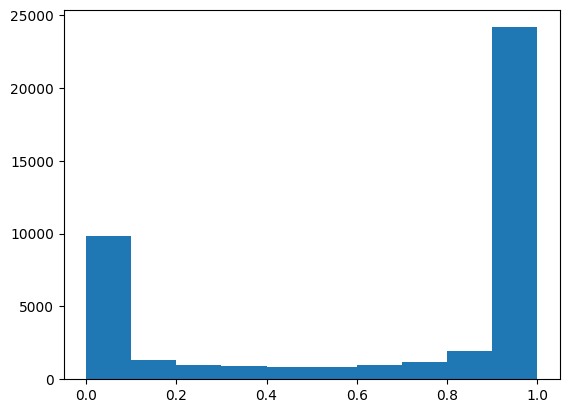

In [170]:
b = a.to_numpy().flatten()
plt.hist(b/(b+1))

In [82]:
pd.read_table("data/rnaseq/rnaseq.rsem_genes_expected_count.txt")

,gene_id,gene_name,0001_GSE86189_Thymus_0,0001_GSE86189_Thymus_1,0001_GSE86189_Thymus_2,0001_GSE86189_Thymus_3,0001_GSE86189_Thymus_4,0002_GSE86189_Embryo - Trophoblast_0,0003_GSE86189_Spleen_0,0003_GSE86189_Spleen_1,...,0064_EGAD00001002268_Blood - Megakaryocytes_1,0064_EGAD00001002268_Blood - Megakaryocytes_2,0067_EGAD00001002268_Blood - Total CD4+ Cells_0,0067_EGAD00001002268_Blood - Total CD4+ Cells_1,0067_EGAD00001002268_Blood - Total CD4+ Cells_2,0067_EGAD00001002268_Blood - Total CD4+ Cells_3,0067_EGAD00001002268_Blood - Total CD4+ Cells_4,0067_EGAD00001002268_Blood - Total CD4+ Cells_5,0067_EGAD00001002268_Blood - Total CD4+ Cells_6,0067_EGAD00001002268_Blood - Total CD4+ Cells_7
0,ENSG00000223972,DDX11L1,0.0,2.40,4.45,3.82,5.13,3.00,0.00,0.00,...,267.17,139.81,0.00,0.00,0.00,0.0,0.0,0.00,2.53,0.0
1,ENSG00000243485,MIR1302-2HG,0.0,0.00,0.00,0.00,0.00,2.32,0.00,0.50,...,0.00,0.00,0.00,0.00,0.00,0.0,1.0,0.00,0.00,0.0
2,ENSG00000227232,WASH7P,653.2,665.92,380.16,664.76,700.23,1359.10,259.51,225.03,...,119.80,176.66,765.28,688.52,566.35,285.1,1296.1,348.48,625.77,606.3
3,ENSG00000237613,FAM138A,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.33,0.00,0.50,0.0,0.0,1.00,0.00,0.0
4,ENSG00000268020,OR4G4P,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57415,ENSG00000224240,CYCSP49,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0
57416,ENSG00000227629,SLC25A15P1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0
57417,ENSG00000231514,FAM58CP,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0
57418,ENSG00000237917,PARP4P1,0.0,0.00,0.00,1.00,1.00,19.00,0.00,0.00,...,0.00,0.00,3.00,9.24,11.00,6.0,0.0,0.00,6.01,6.0
